In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, cohen_kappa_score, roc_curve, make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report

In [2]:
X = pd.read_csv('../../data/4-modelling/1-datainput/aaindex-morgan_bindingdb.csv')
y = X.pop('Class')
X

,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,BHAR880101,BIGC670101,BIOV880101,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1.481179,0.352386,-0.917555,-0.859283,-0.851430,0.637549,0.663336,-0.204360,0.324345,0.464680,...,0,0,0,0,0,0,0,0,0,0
1,1.481179,0.352386,-0.917555,-0.859283,-0.851430,0.637549,0.663336,-0.204360,0.324345,0.464680,...,0,0,0,1,0,0,0,0,0,0
2,1.481179,0.352386,-0.917555,-0.859283,-0.851430,0.637549,0.663336,-0.204360,0.324345,0.464680,...,0,0,0,0,0,0,0,0,0,0
3,1.481179,0.352386,-0.917555,-0.859283,-0.851430,0.637549,0.663336,-0.204360,0.324345,0.464680,...,0,0,0,0,0,1,0,0,0,0
4,1.481179,0.352386,-0.917555,-0.859283,-0.851430,0.637549,0.663336,-0.204360,0.324345,0.464680,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81343,0.994132,0.154407,-1.140806,-1.170090,-0.865202,-0.800417,1.080870,0.566824,0.016364,-0.815901,...,0,0,0,0,0,1,0,0,0,0
81344,0.994132,0.154407,-1.140806,-1.170090,-0.865202,-0.800417,1.080870,0.566824,0.016364,-0.815901,...,0,0,0,0,0,1,0,0,0,0
81345,-0.594270,-0.237861,-0.745444,-0.688045,0.185063,-0.993074,0.162739,1.243535,-0.118940,-1.092745,...,0,0,0,0,0,1,0,0,0,0
81346,-0.594270,-0.237861,-0.745444,-0.688045,0.185063,-0.993074,0.162739,1.243535,-0.118940,-1.092745,...,0,0,0,0,0,1,0,0,0,0


In [3]:
y

0        1
1        1
2        1
3        1
4        1
        ..
81343    0
81344    0
81345    0
81346    0
81347    0
Name: Class, Length: 81348, dtype: int64

In [4]:
if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
    X = X.values
if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
    y = y.values

In [5]:
# Models
models = {
    #"MLP": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    #"XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    #"Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Cross-validation and metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = [
    ("Accuracy", accuracy_score),
    ("Recall", recall_score),
    ("Precision", precision_score),
    ("F1-Score", f1_score),
    ("AUC", roc_auc_score),
    ("Cohen Kappa", cohen_kappa_score)
]

results = []

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    
    metric_scores = {metric[0]: [] for metric in metrics}
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        for metric_name, metric_func in metrics:
            if metric_name == "AUC" and y_proba is not None:
                score = metric_func(y_test, y_proba)
            elif metric_name != "AUC":
                score = metric_func(y_test, y_pred)
            else:
                score = np.nan
            
            metric_scores[metric_name].append(score)

    result = {
        "Model": model_name,
        **{f"Mean {metric[0]}": np.mean(scores) for metric, scores in zip(metrics, metric_scores.values())},
        **{f"Std {metric[0]}": np.std(scores) for metric, scores in zip(metrics, metric_scores.values())}
    }
    results.append(result)

# Save results to CSV
results_df = pd.DataFrame(results)

Evaluating Random Forest...
Evaluating Logistic Regression...


In [6]:
results_df

,Model,Mean Accuracy,Mean Recall,Mean Precision,Mean F1-Score,Mean AUC,Mean Cohen Kappa,Std Accuracy,Std Recall,Std Precision,Std F1-Score,Std AUC,Std Cohen Kappa
0,Random Forest,0.995784,0.994985,0.996577,0.995780,0.999909,0.991567,0.000448,0.000693,0.000285,0.000449,0.000007,0.000895
1,Logistic Regression,0.719919,0.694989,0.731456,0.712754,0.810488,0.439839,0.002543,0.004007,0.002186,0.002999,0.001259,0.005086


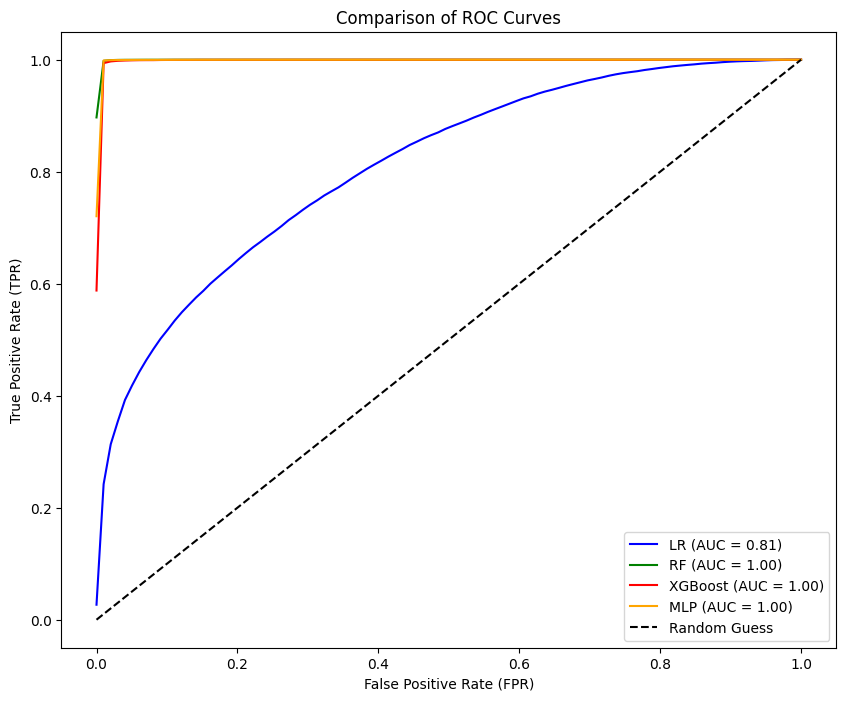

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Fungsi untuk menghitung rata-rata ROC dan AUC
def compute_mean_roc(roc_df, label):
    # Interpolasi TPR berdasarkan FPR yang sama
    fpr_values = np.linspace(0, 1, 100)
    tpr_interpolated = []
    
    for fold in roc_df['Fold'].unique():
        fold_data = roc_df[roc_df['Fold'] == fold]
        tpr_interp = np.interp(fpr_values, fold_data['FPR'], fold_data['TPR'])
        tpr_interpolated.append(tpr_interp)
    
    # Hitung rata-rata dan standar deviasi TPR
    tpr_mean = np.mean(tpr_interpolated, axis=0)
    tpr_std = np.std(tpr_interpolated, axis=0)
    
    # Hitung AUC rata-rata
    mean_auc = auc(fpr_values, tpr_mean)
    
    return fpr_values, tpr_mean, tpr_std, mean_auc

# Load file ROC dari model 1 dan 2
roc_df_model1 = pd.read_csv("../../data/4-modelling/result/bindingdb/AAIndex-Morgan/roc_curve_logistic_regression.csv")
roc_df_model2 = pd.read_csv("../../data/4-modelling/result/bindingdb/AAIndex-Morgan/roc_curve_random_forest.csv")
roc_df_model3 = pd.read_csv("../../data/4-modelling/result/bindingdb/AAIndex-Morgan/roc_curve_xgboost.csv")
roc_df_model4 = pd.read_csv("../../data/4-modelling/result/bindingdb/AAIndex-Morgan/roc_curve_mlp.csv")

# Hitung ROC rata-rata untuk kedua model
fpr1, tpr1_mean, tpr1_std, auc1 = compute_mean_roc(roc_df_model1, "LR")
fpr2, tpr2_mean, tpr2_std, auc2 = compute_mean_roc(roc_df_model2, "RF")
fpr3, tpr3_mean, tpr3_std, auc3 = compute_mean_roc(roc_df_model3, "XGBoost")
fpr4, tpr4_mean, tpr4_std, auc4 = compute_mean_roc(roc_df_model4, "MLP")

# Plot ROC Curve untuk kedua model
plt.figure(figsize=(10, 8))

# Model 1
plt.plot(fpr1, tpr1_mean, label=f"LR (AUC = {auc1:.2f})", color="blue")
plt.plot(fpr2, tpr2_mean, label=f"RF (AUC = {auc2:.2f})", color="green")
plt.plot(fpr3, tpr3_mean, label=f"XGBoost (AUC = {auc3:.2f})", color="red")
plt.plot(fpr4, tpr4_mean, label=f"MLP (AUC = {auc4:.2f})", color="orange")

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Tambahkan label dan judul
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Comparison of ROC Curves")
plt.legend(loc="lower right")

# Simpan plot ke file
plt.savefig("../../data/4-modelling/result/comparison_roc_curve_plot.png", format='png', dpi=300, bbox_inches='tight')
plt.show()